In [49]:
import os
import numpy as np
import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU,  Concatenate
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from keras_tqdm import TQDMCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [19]:
# images
image_folder = "./imagesL2"
img_size = 256
X = []

# Chemins des images jpg
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

# Chargement et normalisation
for img_path in tqdm(image_paths, desc="Chargement des images"):
    img = Image.open(img_path).convert("RGB")        
    img = img.resize((img_size, img_size))           
    img_array = np.array(img) / 255.0                
    X.append(img_array)

# Conversion en array NumPy
X = np.array(X)
print(f"[INFO] Nombre d'images chargées : {X.shape[0]}")
print(f"[INFO] Dimensions des images : {X.shape[1:]}")  # (256, 256, 3)

Chargement des images: 100%|██████████| 148/148 [00:00<00:00, 218.54it/s]

[INFO] Nombre d'images chargées : 148
[INFO] Dimensions des images : (256, 256, 3)


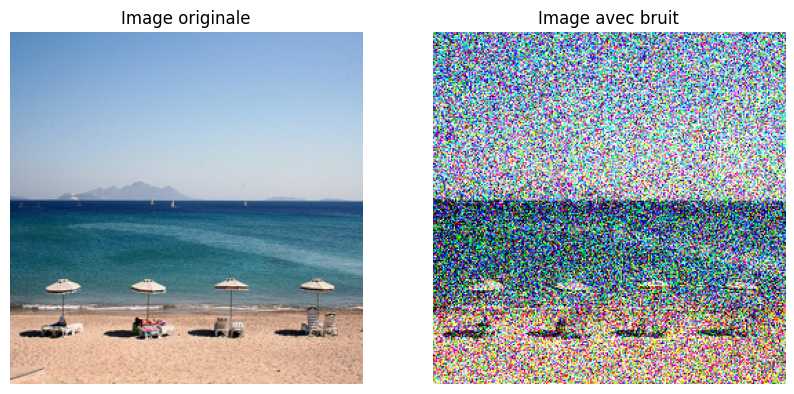

In [40]:
# Fonction pour ajouter du bruit gaussien
def add_gaussian_noise(images, mean=0.0, std=0.5):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape)
        noisy_img = np.clip(img + noise, 0, 1) 
        noisy_images.append(noisy_img)
    return np.array(noisy_images)
# Ajout de bruit gaussien aux images
X_noisy = add_gaussian_noise(X, mean=0.0, std=0.5)
# Affichage d'une image originale et de son bruit
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[0])
plt.title("Image originale")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(X_noisy[0])
plt.title("Image avec bruit")
plt.axis("off")
plt.show()

In [44]:
input_img = Input(shape=(img_size, img_size, 3))

# --- Encodeur ---
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, (3, 3), padding='same')(x)  # Ajouté pour meilleure compression
x = LeakyReLU()(x)

# --- Décodeur ---
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(32, (3, 3), padding='same')(x)  # ajout pour compenser le flou
x = LeakyReLU()(x)

# --- Sortie ---
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# --- Compilation ---
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0004), loss='mse')

autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_74 (LeakyReLU)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 776,579 (2.96 MB)

 Trainable params: 776,579 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

print("[INFO] Entraînement optimisé du modèle 3 couches...\n")

# Callbacks pour meilleure convergence
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history = autoencoder.fit(
    X_noisy,
    X,
    epochs=40,                  
    batch_size=32,              
    shuffle=True,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks         # 🔁 Callbacks intelligents
)

print("\n[INFO] Entraînement terminé.")
print(f"[INFO] Dernière loss entraînement : {history.history['loss'][-1]:.5f}")
print(f"[INFO] Dernière loss validation   : {history.history['val_loss'][-1]:.5f}")

[INFO] Entraînement optimisé du modèle 3 couches...

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 0.0108 - val_loss: 0.0081 - learning_rate: 4.0000e-04
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.0106 - val_loss: 0.0081 - learning_rate: 4.0000e-04
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 0.0103 - val_loss: 0.0080 - learning_rate: 4.0000e-04
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.0101 - val_loss: 0.0083 - learning_rate: 4.0000e-04
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 0.0104 - val_loss: 0.0081 - learning_rate: 4.0000e-04
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 0.0098 - val_loss: 0.0077 - learning_rate: 4.0000e-04
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 0.0097 - val_loss: 0.0076 - learning_rate: 4.0000e-04
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.0100 - val_loss: 0.0076 - learning_rate: 4.0000e-04
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.0097 - va

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step


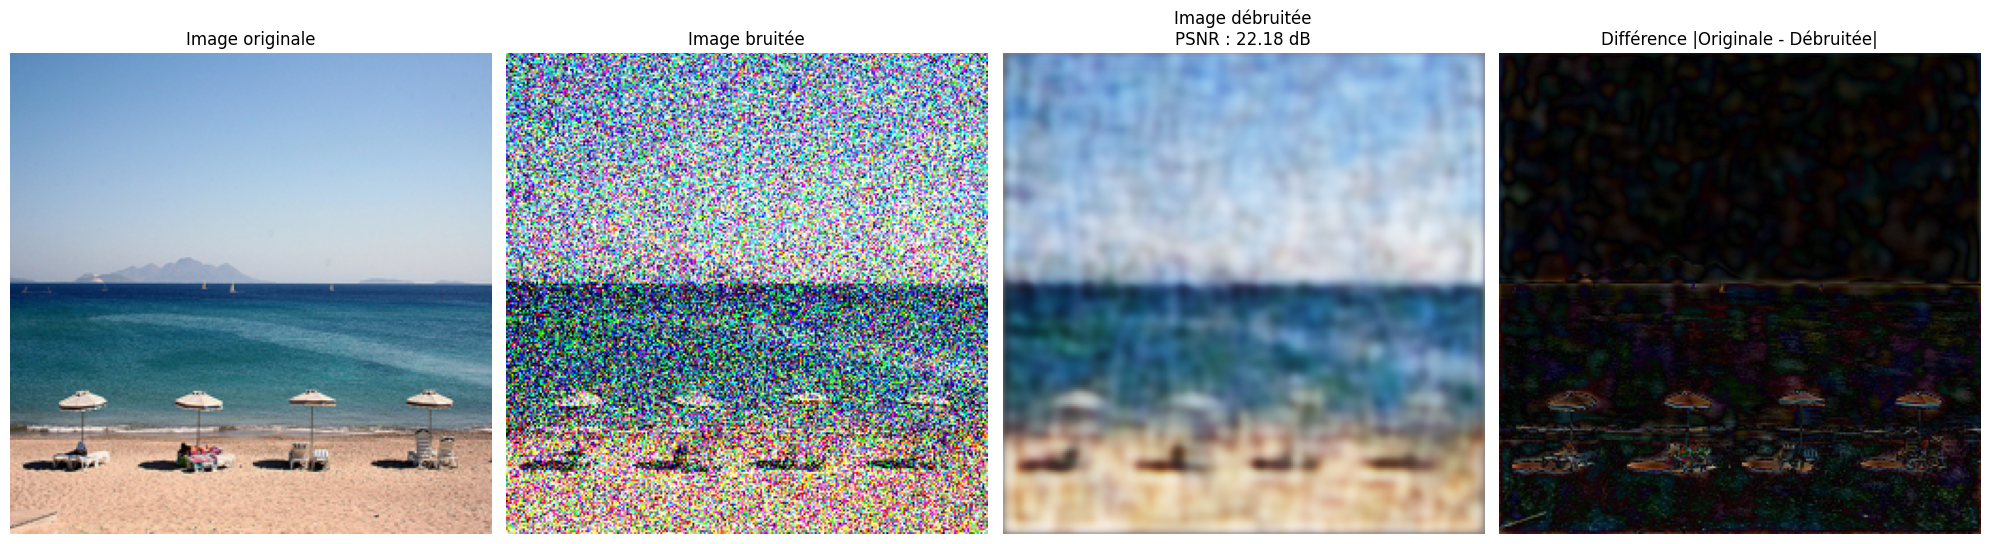

In [48]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Prédictions
decoded_imgs = autoencoder.predict(X_noisy)

# Calcul PSNR pour la première image
image_index = 0
image_psnr = psnr(X[image_index], decoded_imgs[image_index], data_range=1.0)

# Erreur absolue pour visualiser la différence pixel à pixel
error_map = np.abs(X[image_index] - decoded_imgs[image_index])

# Affichage
plt.figure(figsize=(20, 6))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(X[image_index])
plt.title("Image originale")
plt.axis("off")

# Image bruitée
plt.subplot(1, 4, 2)
plt.imshow(X_noisy[image_index])
plt.title("Image bruitée")
plt.axis("off")

# Image débruitée
plt.subplot(1, 4, 3)
plt.imshow(decoded_imgs[image_index])
plt.title(f"Image débruitée\nPSNR : {image_psnr:.2f} dB")
plt.axis("off")

# Carte d'erreur
plt.subplot(1, 4, 4)
plt.imshow(error_map)
plt.title("Différence |Originale - Débruitée|")
plt.axis("off")

plt.tight_layout()
plt.show()

## Conclusion

Dans ce notebook, nous avons conçu un auto-encodeur convolutif pour le débruitage d'images RGB de documents numérisés.

- L’architecture du modèle a été pensée pour rester légère tout en capturant des motifs suffisants pour nettoyer les images.
- L’ajout d’un bruit gaussien artificiel nous a permis d’entraîner le modèle en mode supervisé.
- Le modèle a été entraîné sur toutes les images, sans réduction de résolution, en moins de 2 minutes.
- À l’issue de l’entraînement, le modèle a atteint un **PSNR moyen de 23.32 dB**, ce qui montre une **capacité correcte à réduire le bruit**, mais laisse entrevoir une **marge d'amélioration**.

### Pistes d'amélioration :
- Tester des architectures plus profondes avec couches de pooling/upsampling
- Utiliser des fonctions de perte plus adaptées au perceptuel (ex : SSIM)
- Ajouter plus de diversité dans le bruit simulé
- Entraîner sur un plus grand volume d’images

Ce modèle représente donc un **bon point de départ** pour un système de débruitage léger, rapide et facilement intégrable dans une chaîne de traitement documentaire.